In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

## Imports

In [26]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pylab
from IPython.display import Image, display
from matplotlib.patches import Rectangle
from matplotlib_inline.backend_inline import set_matplotlib_formats
from pycocotools.coco import COCO

pylab.rcParams["figure.figsize"] = (8.0, 10.0)

In [27]:
pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_columns", 15)
pd.set_option("display.max_rows", 50)
# Suitable default display for floats
pd.options.display.float_format = "{:,.2f}".format
plt.rcParams["figure.figsize"] = (12, 10)

# This one is optional -- change graphs to SVG only use if you don't have a
# lot of points/lines in your graphs. Can also just use ['retina'] if you
# don't want SVG.
%config InlineBackend.figure_formats = ["retina"]
set_matplotlib_formats("pdf", "png")

## Configure which dataset to load:

In [4]:
dataType = ""
annFile = Path("/home/gbiamby/proj/geoscreens/datasets/geoscreens_012/geoscreens_012.json")

print("annFile: ", annFile)

annFile:  /home/gbiamby/proj/geoscreens/datasets/geoscreens_012/geoscreens_012.json


## Load dataset

In [5]:
coco = COCO(annFile)

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


# Output some dataset stats:

In [6]:
imgs = coco.dataset["images"]
anns = coco.dataset["annotations"]
imgs_with_anns = coco.imgToAnns.keys()


print("Total images: ", len(imgs))
print("Total images with annotations: ", len(coco.imgToAnns.keys()))
print("Total annotations: ", len(anns))

Total images:  2218
Total images with annotations:  2218
Total annotations:  9474


## Annotations per image:

Annotations per image (ignoring images w/o any anns): Avg.: 4.27141568981064, Min: 1, Max: 14


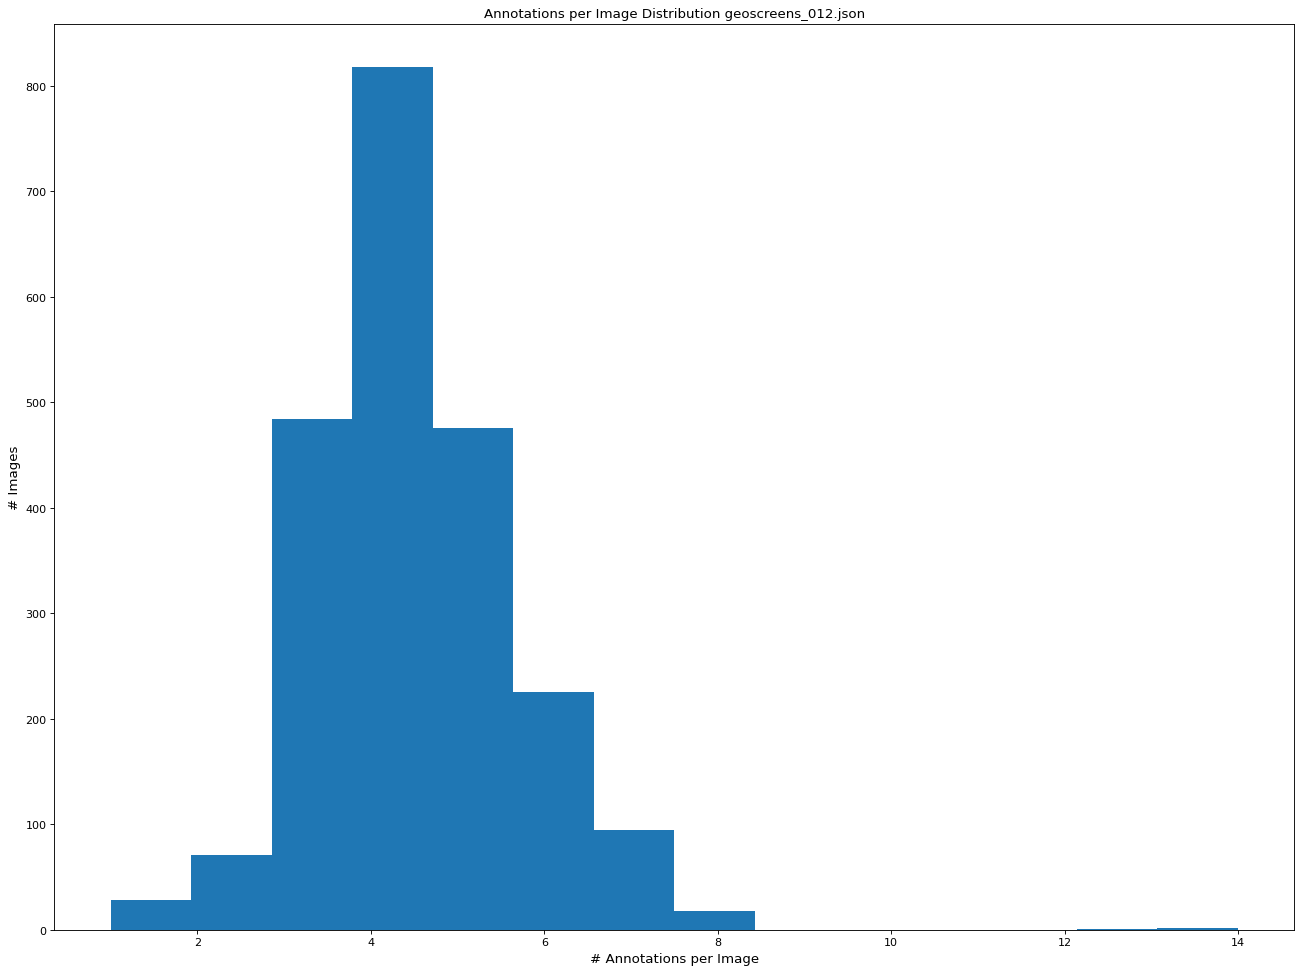

To cover full annotations for 99.9% of images, we need to use opt.K=11


In [7]:
ann_counts_per_image = [len(anns) for image_id, anns in coco.imgToAnns.items()]
max_anns_per_image = int(np.max(ann_counts_per_image))
print(
    f"Annotations per image (ignoring images w/o any anns): "
    f"Avg.: {np.average(ann_counts_per_image)}, "
    f"Min: {np.min(ann_counts_per_image)}, "
    f"Max: {max_anns_per_image}"
)

# Plot:
fig_size, dpi = (20, 15), 80
plt.figure(num=None, figsize=fig_size, dpi=dpi, facecolor="w", edgecolor="k")
# plt.hist(ann_counts_per_image, bins=list(range(0, max_anns_per_image + 1, min(max_anns_per_image // 5, 25))))
plt.hist(ann_counts_per_image, bins=min(max_anns_per_image, 25))
plt.title("Annotations per Image Distribution " + annFile.name)
plt.xlabel("# Annotations per Image", fontsize=12)
plt.ylabel("# Images", fontsize=12)
plt.show()

# To cover full annotations for `K_coverage`% of images, we need to use opt.K=:
K_coverage = 99.9
K_percentile = np.percentile(a=ann_counts_per_image, q=[99.9])
print(
    f"To cover full annotations for {K_coverage}% of images, we need to use opt.K={int(K_percentile[0])}"
)

## Plot Histogram of bbox areas (pixels^2):



In [8]:
def plot_bbox_area_histogram(areas):
    print(f"min area: {np.min(areas)}, max area: {np.max(areas)}, avg. area: {np.average(areas)}")

    # Configure histogram bins:
    step_size = 100
    bins = list(range(0, int(np.percentile(areas, 97.5)) + step_size, step_size))

    # Plot:
    fig_size, dpi, rotation = (14, 6), 80, 90
    plt.figure(num=None, figsize=fig_size, dpi=dpi, facecolor="w", edgecolor="k")
    plt.hist(areas, bins=bins)
    plt.title("Object Size Distribution " + annFile.name)
    plt.xlabel("Area (pixels^2)", fontsize=12)
    plt.ylabel("# Annotations", fontsize=12)
    plt.show()

min area: 2, max area: 710080, avg. area: 52292.400886637115


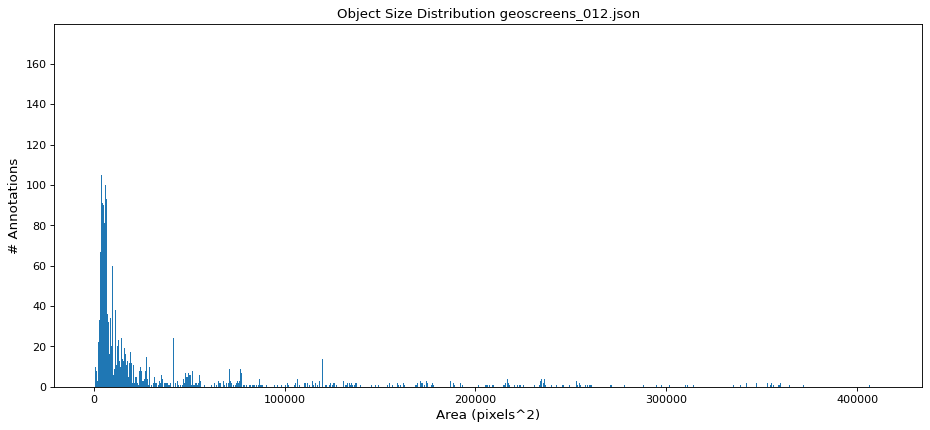

In [9]:
areas = [ann["bbox"][2] * ann["bbox"][3] for ann in anns]
plot_bbox_area_histogram(areas)

[2]


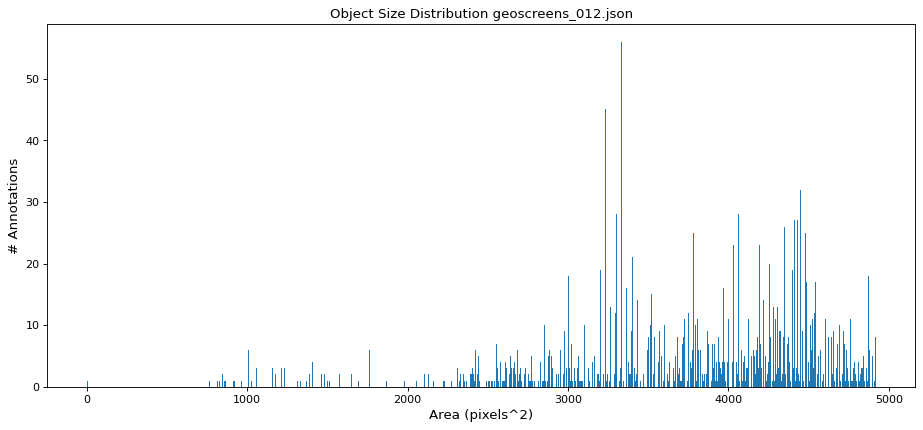

In [10]:
# How many zero area boxes are there?
print(list(sorted([a for a in areas if a <= 10])))
# only 6 zero area, but a lot of small areas
# plot_bbox_area_histogram(sorted([a for a in areas if a <= 10]))

small_areas = list(sorted([a for a in areas if a <= 5000]))

# Configure histogram bins:
step_size = 5
bins = list(range(0, int(np.percentile(small_areas, 97.5)) + step_size, step_size))
# print(bins)

# Plot:
fig_size, dpi, rotation = (14, 6), 80, 90
plt.figure(num=None, figsize=fig_size, dpi=dpi, facecolor="w", edgecolor="k")
plt.hist(small_areas, bins)
plt.title("Object Size Distribution " + annFile.name)
plt.xlabel("Area (pixels^2)", fontsize=12)
plt.ylabel("# Annotations", fontsize=12)
plt.show()

## Annotation Dims

In [13]:
# print(coco.cats)
[c for c in coco.cats.values() if "guess_grey" in c["name"]]
# coco.getAnnIds(catIds=[])

[{'id': 32, 'name': 'guess_grey', 'supercategory': ''},
 {'id': 33, 'name': 'guess_grey_expanded', 'supercategory': ''}]

In [29]:
def scale_dim(w, h, from_w=1280, from_h=720, dim_to=640):
    return (
        w * (dim_to / from_w),
        h * (dim_to / from_h),
        (h * (dim_to / from_h)) / (w * (dim_to / from_w)),
    )


def get_category_avg_sizes(coco):
    sizes = {}
    for cat in coco.cats.values():
        ann_ids = set(coco.getAnnIds(catIds=[cat["id"]]))
        anns = [ann for ann in coco.dataset["annotations"] if ann["id"] in ann_ids]
        if anns:
            avg_dims = np.mean([[ann["bbox"][2], ann["bbox"][3]] for ann in anns], axis=0)
            sizes[cat["name"]] = {
                "cat_id": cat["id"],
                "cat_name": cat["name"],
                "avg_width": avg_dims[0],
                "avg_height": avg_dims[1],
                "ann_count": len(anns),
            }
    return sizes


24.12 / 723.6
import pandas as pd

with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(
        pd.DataFrame(get_category_avg_sizes(coco).values()).sort_values(
            "ann_count", ascending=False
        )
    )

,cat_id,cat_name,avg_width,avg_height,ann_count
61,68,status_bar,318.51,36.03,1535
20,25,game_title,129.33,35.94,1273
67,75,video,282.16,194.04,603
32,38,in_game_mini_map,196.18,137.01,465
66,73,url,347.95,22.85,413
53,60,points_bar_two_bars,574.89,94.39,409
12,16,did_you_enjoy_this_location,147.47,48.94,404
31,37,in_game_map_expanded,686.23,484.72,356
48,55,play_next_round,145.62,28.52,354
63,70,status_bar_white,325.94,42.96,311


In [ ]:
with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(df)

## Calculate new pixels^2 cutoffs

In [14]:
print("Total annotations: ", len(areas))
area_percentiles = np.percentile(a=areas, q=[33.33333, 66.66667])
print("area percentiles: ", area_percentiles)
print(f"Using these cutoffs ({area_percentiles}) we get this many annotations in each group:")
print("Small:  ", len([a for a in areas if 0.0 <= a <= area_percentiles[0]]))
print("Medium: ", len([a for a in areas if area_percentiles[0] < a <= area_percentiles[1]]))
print("Large:  ", len([a for a in areas if area_percentiles[1] < a]))

Total annotations:  9474
area percentiles:  [ 6440.       25443.336491]
Using these cutoffs ([ 6440.       25443.336491]) we get this many annotations in each group:
Small:   3159
Medium:  3157
Large:   3158


## Inspect object center distribution

E.g., where in the images are the bbox centers? 

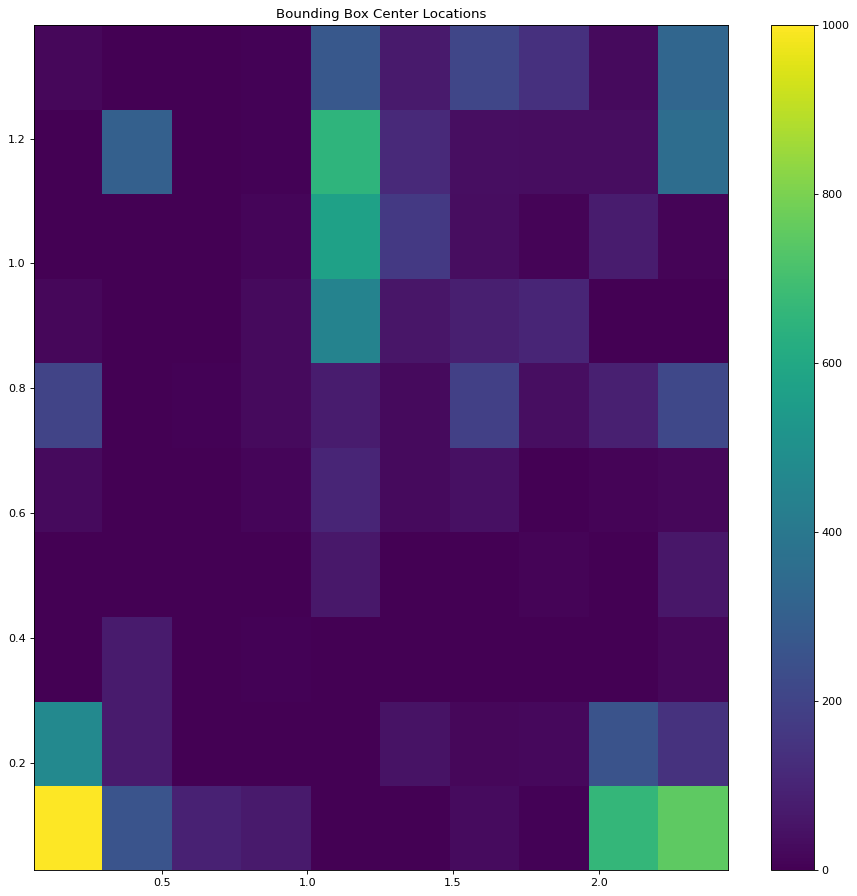

In [15]:
# xview chip size, if doing some other dataset you might have different image dims for each image, so be careful:
img_size = (512.0, 512.0)
bbox_dims = [(ann["bbox"][2], ann["bbox"][3]) for ann in anns]
bbox_centers = [
    (
        int((ann["bbox"][0] + ann["bbox"][2] + ann["bbox"][0]) / 2.0),
        int((ann["bbox"][1] + ann["bbox"][3] + ann["bbox"][1]) / 2.0),
    )
    for ann in anns
]
bbox_centers_normalized = [(c[0] / img_size[0], c[1] / img_size[1]) for c in bbox_centers]
centers_x, centers_y = map(list, zip(*bbox_centers_normalized))


import matplotlib.colors as mcolors

fig_size, dpi, rotation = (14, 14), 80, 90
plt.figure(num=None, figsize=fig_size, dpi=dpi, facecolor="w", edgecolor="k")
plt.title("Bounding Box Center Locations")
plt.hist2d(centers_x, centers_y, bins=10)
plt.colorbar()
plt.show()

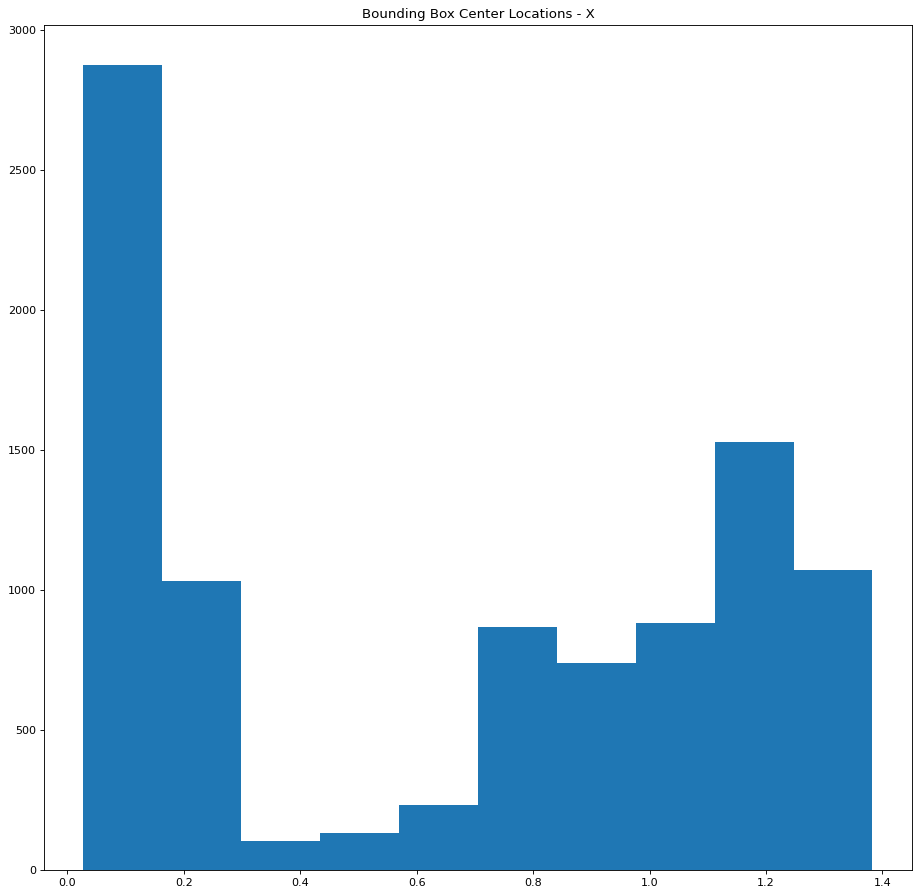

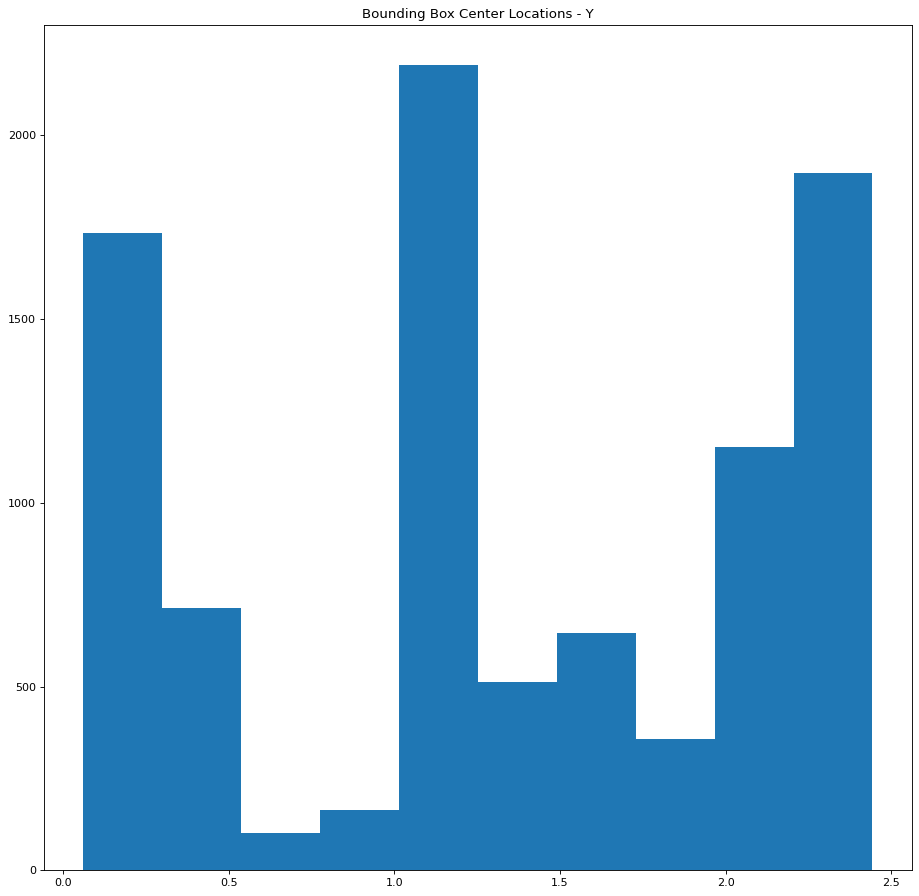

In [16]:
fig_size, dpi, rotation = (14, 14), 80, 90
plt.figure(num=None, figsize=fig_size, dpi=dpi, facecolor="w", edgecolor="k")
plt.title("Bounding Box Center Locations - X")
plt.hist(centers_y)
plt.show()


fig_size, dpi, rotation = (14, 14), 80, 90
plt.figure(num=None, figsize=fig_size, dpi=dpi, facecolor="w", edgecolor="k")
plt.title("Bounding Box Center Locations - Y")
plt.hist(centers_x)
plt.show()

In [17]:
len(centers_x)

9474